In [1]:
# Core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Hugging Face
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

# Utils
import numpy as np
from tqdm.auto import tqdm


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


### 1. Choose a text-only dataset (STS-B)

In [2]:
# STS-B from GLUE
device = "cuda" if torch.cuda.is_available() else "cpu"
raw_datasets = load_dataset("glue", "stsb")
raw_datasets


DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1379
    })
})

### Load a good text encoder (frozen)

In [3]:
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
base_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

# We'll freeze the base model's parameters
for p in base_model.parameters():
    p.requires_grad = False

base_model.eval()
base_model.hidden_size = base_model.config.hidden_size
base_model.hidden_size


384

### Sentence embedding function (mean pooling)

In [4]:
def mean_pool(last_hidden_state, attention_mask):
    # last_hidden_state: (B, T, H)
    # attention_mask: (B, T)
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)  # (B, T, 1)
    summed = (last_hidden_state * mask).sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

@torch.no_grad()
def encode_sentences(texts, batch_model=base_model, batch_tokenizer=tokenizer, device="cpu"):
    enc = batch_tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=64,
        return_tensors="pt"
    ).to(device)
    outputs = batch_model(**enc)
    sentence_embeddings = mean_pool(outputs.last_hidden_state, enc["attention_mask"])
    return sentence_embeddings  # (B, hidden_dim)


### Build a PyTorch-friendly dataset

In [5]:
train_ds = raw_datasets["train"]
val_ds   = raw_datasets["validation"]

def stsb_collate(batch, tokenizer=tokenizer, device="cpu"):
    s1 = [b["sentence1"] for b in batch]
    s2 = [b["sentence2"] for b in batch]
    labels = torch.tensor([b["label"] for b in batch], dtype=torch.float32)

    enc1 = tokenizer(
        s1, padding=True, truncation=True, max_length=64, return_tensors="pt"
    )
    enc2 = tokenizer(
        s2, padding=True, truncation=True, max_length=64, return_tensors="pt"
    )

    batch_enc = {
        "input_ids_1": enc1["input_ids"],
        "attention_mask_1": enc1["attention_mask"],
        "input_ids_2": enc2["input_ids"],
        "attention_mask_2": enc2["attention_mask"],
        "labels": labels,
    }
    return {k: v.to(device) for k, v in batch_enc.items()}


BATCH_SIZE = 64

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda b: stsb_collate(b, device=device),
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda b: stsb_collate(b, device=device),
)


### Define the Linear projector for alignment

In [6]:
class LinearProjector(nn.Module):
    def __init__(self, in_dim, proj_dim):
        super().__init__()
        self.proj = nn.Linear(in_dim, proj_dim)

    def forward(self, x):
        z = self.proj(x)
        z = F.normalize(z, p=2, dim=-1)
        return z

proj_dim = 256
projector = LinearProjector(base_model.hidden_size, proj_dim).to(device)


### Contrastive loss (InfoNCE)

In [7]:
def contrastive_loss(z1, z2, temperature=0.07):
    """
    z1, z2: (B, D) normalized
    """
    batch_size = z1.size(0)
    logits = z1 @ z2.t()  # (B, B)
    logits = logits / temperature

    labels = torch.arange(batch_size, device=z1.device)

    loss_i = F.cross_entropy(logits, labels)         # z1 -> z2
    loss_j = F.cross_entropy(logits.t(), labels)     # z2 -> z1

    return (loss_i + loss_j) / 2


### Training loop (text-only linear projector)

In [8]:
EPOCHS = 10  # start small
LR = 1e-3

projector.train()
optimizer = torch.optim.AdamW(projector.parameters(), lr=LR)

for epoch in range(EPOCHS):
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in pbar:
        # 1. Encode sentences with frozen encoder
        batch = {
        k: v.to(device)
        for k, v in batch.items()
        if isinstance(v, torch.Tensor)
    }
        with torch.no_grad():
            outputs1 = base_model(
                input_ids=batch["input_ids_1"],
                attention_mask=batch["attention_mask_1"],
            )
            h1 = mean_pool(outputs1.last_hidden_state, batch["attention_mask_1"])

            outputs2 = base_model(
                input_ids=batch["input_ids_2"],
                attention_mask=batch["attention_mask_2"],
            )
            h2 = mean_pool(outputs2.last_hidden_state, batch["attention_mask_2"])

        # 2. Project into shared space
        z1 = projector(h1)
        z2 = projector(h2)

        # 3. Contrastive loss
        loss = contrastive_loss(z1, z2, temperature=0.07)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({"loss": total_loss / (len(pbar)+1e-9)})

    print(f"Epoch {epoch+1} done. Avg loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 1 done. Avg loss: 0.6796


Epoch 2/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 2 done. Avg loss: 0.4082


Epoch 3/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 3 done. Avg loss: 0.3208


Epoch 4/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 4 done. Avg loss: 0.2700


Epoch 5/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 5 done. Avg loss: 0.2318


Epoch 6/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 6 done. Avg loss: 0.2201


Epoch 7/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 7 done. Avg loss: 0.2012


Epoch 8/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 8 done. Avg loss: 0.2024


Epoch 9/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 9 done. Avg loss: 0.1775


Epoch 10/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 done. Avg loss: 0.1828


### Quick evaluation: STS-B Spearman correlation

In [9]:
from scipy.stats import spearmanr

projector.eval()

all_scores = []
all_sims   = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Eval"):
        outputs1 = base_model(
            input_ids=batch["input_ids_1"],
            attention_mask=batch["attention_mask_1"],
        )
        h1 = mean_pool(outputs1.last_hidden_state, batch["attention_mask_1"])

        outputs2 = base_model(
            input_ids=batch["input_ids_2"],
            attention_mask=batch["attention_mask_2"],
        )
        h2 = mean_pool(outputs2.last_hidden_state, batch["attention_mask_2"])

        z1 = projector(h1)
        z2 = projector(h2)

        sims = F.cosine_similarity(z1, z2, dim=-1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()

        all_sims.append(sims)
        all_scores.append(labels)

all_sims = np.concatenate(all_sims)
all_scores = np.concatenate(all_scores)

corr, _ = spearmanr(all_sims, all_scores)
print(f"Spearman correlation (val): {corr:.4f}")


Eval:   0%|          | 0/24 [00:00<?, ?it/s]

Spearman correlation (val): 0.8235


## Training with an MLP projector 

In [10]:
class MLPProjector(nn.Module):
    def __init__(self, in_dim, proj_dim, hidden_dim=None):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = proj_dim * 2  # simple heuristic

        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, proj_dim)
        )

    def forward(self, x):
        z = self.net(x)
        z = F.normalize(z, p=2, dim=-1)
        return z

proj_dim = 256
projector = MLPProjector(base_model.hidden_size, proj_dim).to(device)


### Training Loop (Same as Before)

In [11]:
EPOCHS = 10
LR = 1e-3

projector.train()
optimizer = torch.optim.AdamW(projector.parameters(), lr=LR)

for epoch in range(EPOCHS):
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"MLP Projector — Epoch {epoch+1}/{EPOCHS}")

    for batch in pbar:
        with torch.no_grad():
            o1 = base_model(
                input_ids=batch["input_ids_1"],
                attention_mask=batch["attention_mask_1"]
            )
            h1 = mean_pool(o1.last_hidden_state, batch["attention_mask_1"])

            o2 = base_model(
                input_ids=batch["input_ids_2"],
                attention_mask=batch["attention_mask_2"]
            )
            h2 = mean_pool(o2.last_hidden_state, batch["attention_mask_2"])

        z1 = projector(h1)
        z2 = projector(h2)

        loss = contrastive_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({"loss": total_loss / (len(pbar)+1e-9)})

    print(f"Epoch {epoch+1} — Avg Loss: {total_loss/len(train_loader):.4f}")


MLP Projector — Epoch 1/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 1 — Avg Loss: 0.7594


MLP Projector — Epoch 2/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 2 — Avg Loss: 0.4081


MLP Projector — Epoch 3/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 3 — Avg Loss: 0.3306


MLP Projector — Epoch 4/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 4 — Avg Loss: 0.2688


MLP Projector — Epoch 5/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 5 — Avg Loss: 0.2263


MLP Projector — Epoch 6/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 6 — Avg Loss: 0.2118


MLP Projector — Epoch 7/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 7 — Avg Loss: 0.1865


MLP Projector — Epoch 8/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 8 — Avg Loss: 0.1658


MLP Projector — Epoch 9/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 9 — Avg Loss: 0.1615


MLP Projector — Epoch 10/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10 — Avg Loss: 0.1408


### Evaluation (Same STS-B Spearman)

In [12]:
projector.eval()

all_scores = []
all_sims = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating MLP Projector"):
        o1 = base_model(
            input_ids=batch["input_ids_1"],
            attention_mask=batch["attention_mask_1"]
        )
        h1 = mean_pool(o1.last_hidden_state, batch["attention_mask_1"])

        o2 = base_model(
            input_ids=batch["input_ids_2"],
            attention_mask=batch["attention_mask_2"]
        )
        h2 = mean_pool(o2.last_hidden_state, batch["attention_mask_2"])

        z1 = projector(h1)
        z2 = projector(h2)

        sims = F.cosine_similarity(z1, z2, dim=-1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()

        all_sims.append(sims)
        all_scores.append(labels)

all_sims = np.concatenate(all_sims)
all_scores = np.concatenate(all_scores)

corr, _ = spearmanr(all_sims, all_scores)
print(f"Spearman correlation (val): {corr:.4f}")


Evaluating MLP Projector:   0%|          | 0/24 [00:00<?, ?it/s]

Spearman correlation (val): 0.8132


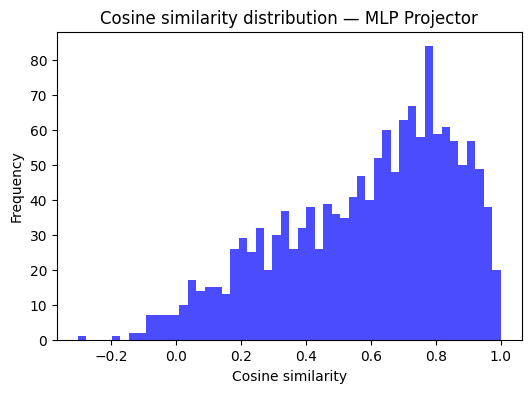

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(all_sims, bins=50, alpha=0.7, color='blue')
plt.title("Cosine similarity distribution — MLP Projector")
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.show()
